In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the data
data = pd.read_csv('raw_sales.csv')

# Handle missing values
data.dropna(inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Impute zero and null values correctly
data['price'] = data['price'].replace(0, np.nan)
data['price'].fillna(method='ffill', inplace=True)

# Indexing date column
data['datesold'] = pd.to_datetime(data['datesold'])
data.set_index('datesold', inplace=True)

print(data.head())



            postcode   price propertyType  bedrooms
datesold                                           
2007-02-07      2607  525000        house         4
2007-02-27      2906  290000        house         3
2007-03-07      2905  328000        house         3
2007-03-09      2905  380000        house         4
2007-03-21      2906  310000        house         3


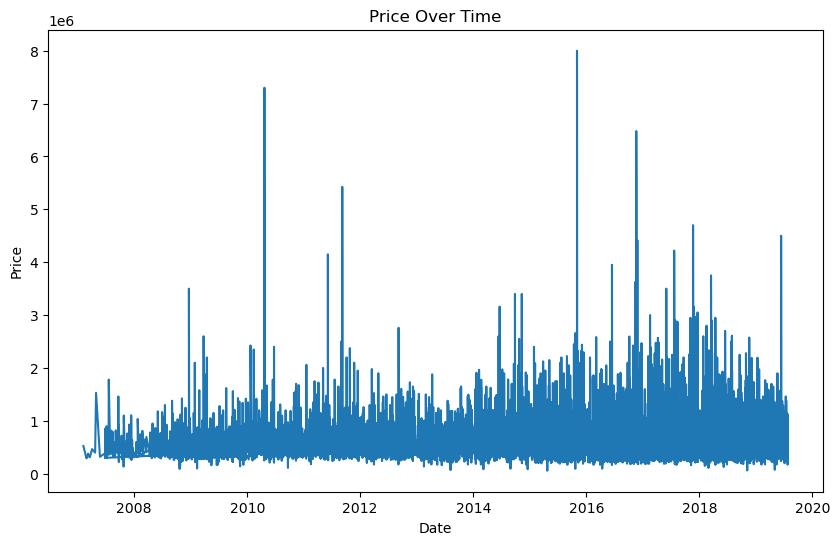

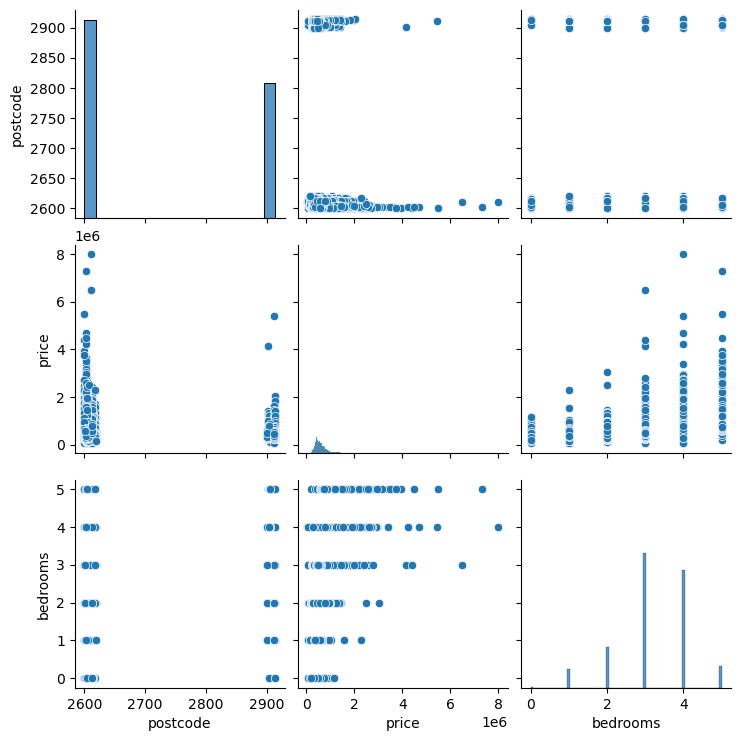

In [6]:
# Plot time series data
plt.figure(figsize=(10, 6))
plt.plot(data['price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Other EDA visualizations
sns.pairplot(data)
plt.show()


# Statistical models with plotting

/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

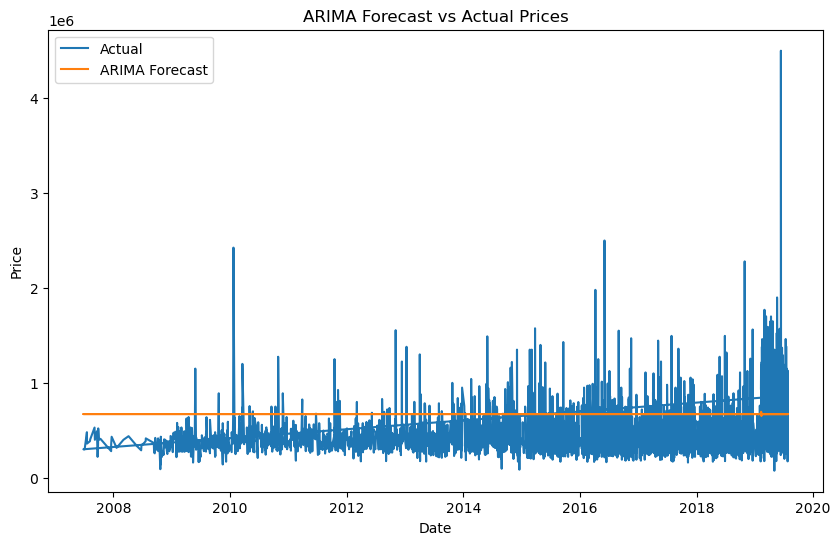

In [7]:
# Train and test sets (80-20 split)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# ARIMA Model
arima_model = ARIMA(train['price'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecasting
arima_forecast = arima_fit.forecast(steps=len(test))

# Compare forecasts with actuals
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['price'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41065D+01    |proj g|=  7.87516D-02


 This problem is unconstrained.



At iterate    5    f=  1.40352D+01    |proj g|=  4.58914D-02

At iterate   10    f=  1.40219D+01    |proj g|=  2.33925D-03

At iterate   15    f=  1.40204D+01    |proj g|=  1.95681D-04
  ys=-1.358E-06  -gs= 2.051E-06 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     40      1     1     0   1.201D-03   1.402D+01
  F =   14.020359134202705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


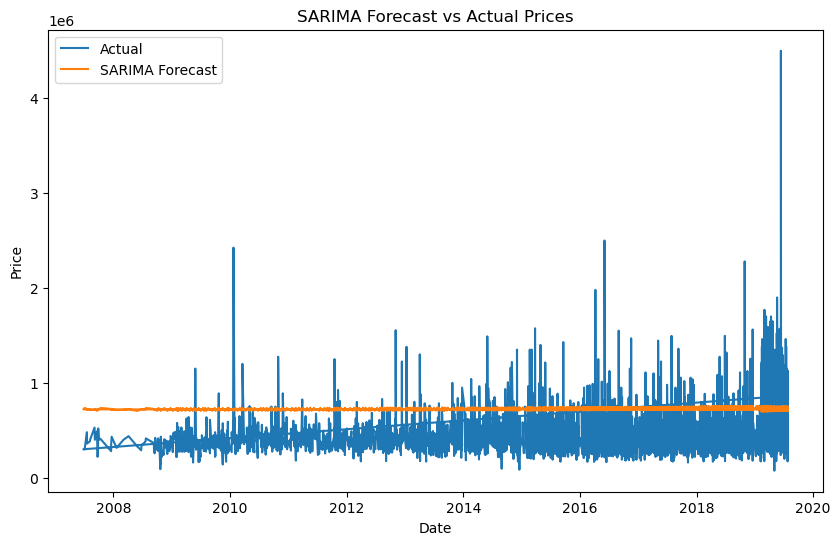

In [8]:
# SARIMA Model
sarima_model = SARIMAX(train['price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Forecasting
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Compare forecasts with actuals
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['price'], label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



In [11]:
# One-hot encode the categorical variable 'propertyType'
data = pd.get_dummies(data, columns=['propertyType'])

# Train and test sets (80-20 split)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Define exogenous variables by dropping the 'price' column
exog_train = train.drop(columns=['price'])
exog_test = test.drop(columns=['price'])

# Ensure exog_train and exog_test have the same columns
exog_test = exog_test.reindex(columns=exog_train.columns, fill_value=0)

print(exog_train.head())
print(exog_test.head())


            postcode  bedrooms  propertyType_house  propertyType_unit
datesold                                                             
2007-02-07      2607         4                   1                  0
2007-02-27      2906         3                   1                  0
2007-03-07      2905         3                   1                  0
2007-03-09      2905         4                   1                  0
2007-03-21      2906         3                   1                  0
            postcode  bedrooms  propertyType_house  propertyType_unit
datesold                                                             
2019-02-08      2913         4                   1                  0
2019-02-09      2603         4                   1                  0
2019-02-11      2906         3                   1                  0
2019-02-11      2905         4                   1                  0
2019-02-11      2906         4                   1                  0


/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

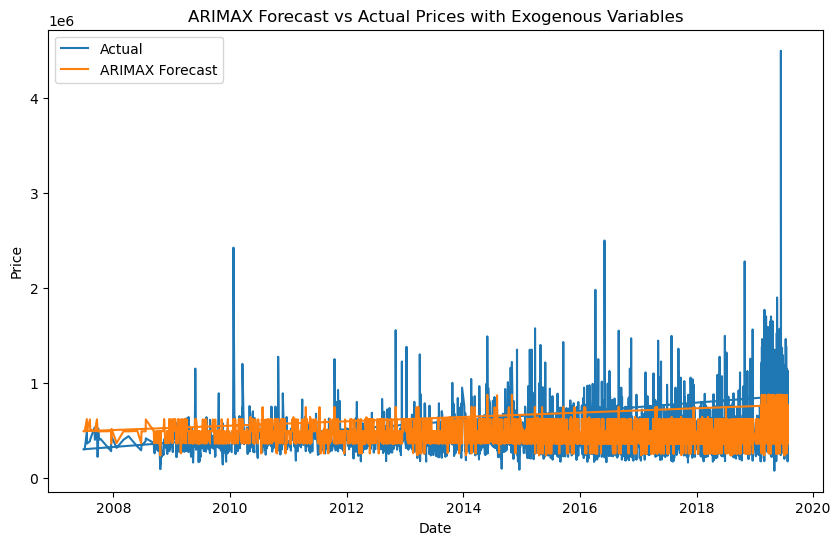

In [12]:
# ARIMAX Model with exogenous variables
arimax_model = ARIMA(train['price'], order=(5, 1, 0), exog=exog_train)
arimax_fit = arimax_model.fit()

# Forecasting with ARIMAX
arimax_forecast = arimax_fit.forecast(steps=len(test), exog=exog_test)

# Compare ARIMAX forecasts with actuals
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['price'], label='Actual')
plt.plot(test.index, arimax_forecast, label='ARIMAX Forecast')
plt.legend()
plt.title('ARIMAX Forecast vs Actual Prices with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39995D+01    |proj g|=  7.99645D-02


 This problem is unconstrained.



At iterate    5    f=  1.39293D+01    |proj g|=  6.51502D-02

At iterate   10    f=  1.39140D+01    |proj g|=  2.80329D-03

At iterate   15    f=  1.39123D+01    |proj g|=  3.84187D-04

At iterate   20    f=  1.39122D+01    |proj g|=  6.40579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     32      1     0     0   1.417D-04   1.391D+01
  F =   13.912229374071245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/mazenfadl/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


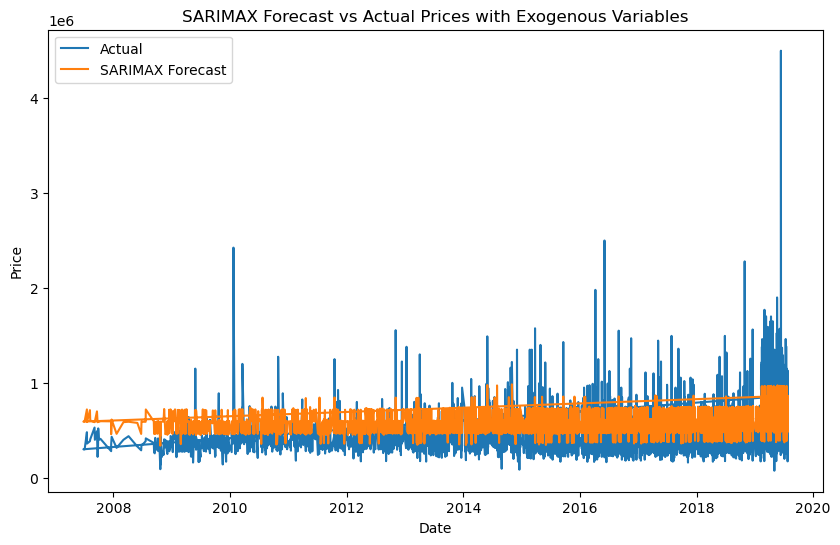

In [13]:
# SARIMAX Model with exogenous variables
sarimax_model = SARIMAX(train['price'], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax_model.fit()

# Forecasting with SARIMAX
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# Compare SARIMAX forecasts with actuals
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['price'], label='Actual')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast')
plt.legend()
plt.title('SARIMAX Forecast vs Actual Prices with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# deep learning models

In [14]:
# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['price']])
test_scaled = scaler.transform(test[['price']])

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 10  # Adjust as needed

# Create sequences for train and test data
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape input data to be 3D [samples, timesteps, features] for CNN and CNN-LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train_cnn.shape)
print("X_test shape:", X_test_cnn.shape)


X_train shape: (23654, 10, 1)
X_test shape: (5906, 10, 1)


In [16]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='mse')

# Train the model
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
cnn_loss = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print("CNN Loss:", cnn_loss)


Epoch 1/50
740/740 [==============================] - 1s 1ms/step - loss: 0.0010
Epoch 2/50
740/740 [==============================] - 1s 1ms/step - loss: 9.5792e-04
Epoch 3/50
740/740 [==============================] - 1s 1ms/step - loss: 9.4186e-04
Epoch 4/50
740/740 [==============================] - 1s 1ms/step - loss: 9.3673e-04
Epoch 5/50
740/740 [==============================] - 1s 1ms/step - loss: 9.2798e-04
Epoch 6/50
740/740 [==============================] - 1s 1ms/step - loss: 9.2781e-04
Epoch 7/50
740/740 [==============================] - 1s 1ms/step - loss: 9.2299e-04
Epoch 8/50
740/740 [==============================] - 1s 1ms/step - loss: 9.1668e-04
Epoch 9/50
740/740 [==============================] - 1s 1ms/step - loss: 9.1463e-04
Epoch 10/50
740/740 [==============================] - 1s 1ms/step - loss: 9.1860e-04
Epoch 11/50
740/740 [==============================] - 1s 1ms/step - loss: 9.1534e-04
Epoch 12/50
740/740 [==============================] - 1s 850us/ste

In [17]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
lstm_loss = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)
print("LSTM Loss:", lstm_loss)


Epoch 1/50
740/740 [==============================] - 4s 4ms/step - loss: 0.0012
Epoch 2/50
740/740 [==============================] - 3s 4ms/step - loss: 9.8170e-04
Epoch 3/50
740/740 [==============================] - 3s 4ms/step - loss: 9.3311e-04
Epoch 4/50
740/740 [==============================] - 3s 4ms/step - loss: 9.1746e-04
Epoch 5/50
740/740 [==============================] - 3s 4ms/step - loss: 9.1787e-04
Epoch 6/50
740/740 [==============================] - 3s 4ms/step - loss: 9.1175e-04
Epoch 7/50
740/740 [==============================] - 3s 4ms/step - loss: 9.1022e-04
Epoch 8/50
740/740 [==============================] - 3s 4ms/step - loss: 9.0316e-04
Epoch 9/50
740/740 [==============================] - 3s 4ms/step - loss: 9.0695e-04
Epoch 10/50
740/740 [==============================] - 3s 4ms/step - loss: 9.0570e-04
Epoch 11/50
740/740 [==============================] - 3s 4ms/step - loss: 9.0212e-04
Epoch 12/50
740/740 [==============================] - 3s 4ms/step 

In [18]:
# Define CNN-LSTM model
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
cnn_lstm_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
cnn_lstm_loss = cnn_lstm_model.evaluate(X_test_cnn, y_test, verbose=0)
print("CNN-LSTM Loss:", cnn_lstm_loss)


Epoch 1/50
740/740 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 2/50
740/740 [==============================] - 2s 3ms/step - loss: 9.6067e-04
Epoch 3/50
740/740 [==============================] - 2s 3ms/step - loss: 9.4408e-04
Epoch 4/50
740/740 [==============================] - 2s 3ms/step - loss: 9.3184e-04
Epoch 5/50
740/740 [==============================] - 2s 3ms/step - loss: 9.3058e-04
Epoch 6/50
740/740 [==============================] - 2s 3ms/step - loss: 9.1842e-04
Epoch 7/50
740/740 [==============================] - 2s 2ms/step - loss: 9.2060e-04
Epoch 8/50
740/740 [==============================] - 2s 3ms/step - loss: 9.1860e-04
Epoch 9/50
740/740 [==============================] - 2s 3ms/step - loss: 9.1561e-04
Epoch 10/50
740/740 [==============================] - 2s 3ms/step - loss: 9.0939e-04
Epoch 11/50
740/740 [==============================] - 2s 3ms/step - loss: 9.0496e-04
Epoch 12/50
740/740 [==============================] - 1s 2ms/step 

# plot deep learning models

185/185 [==============================] - 1s 640us/step


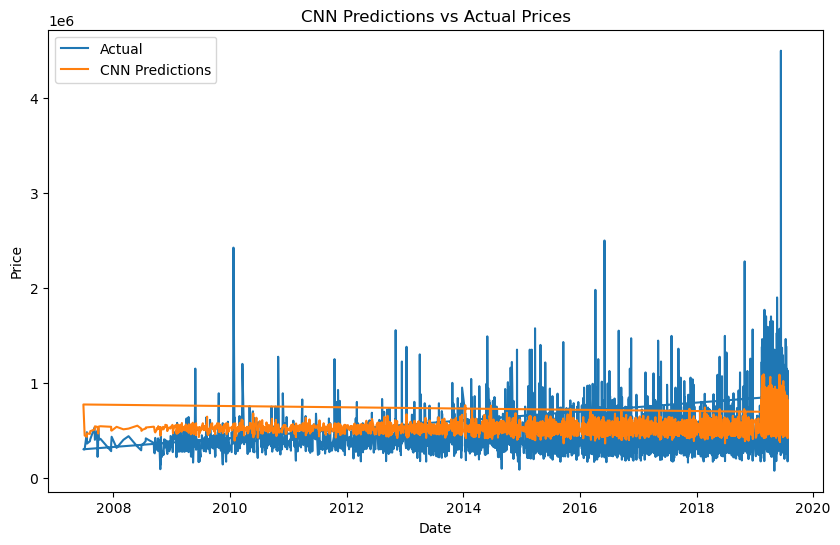

185/185 [==============================] - 0s 1ms/step


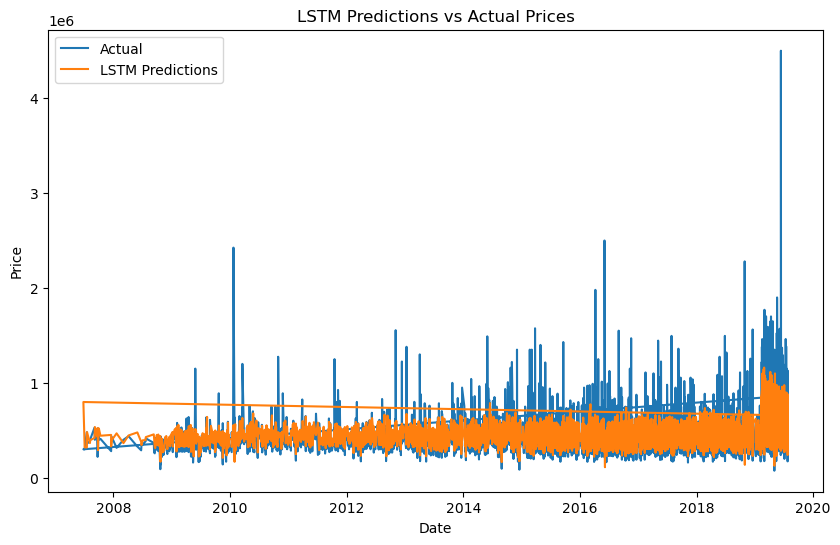

185/185 [==============================] - 0s 1ms/step


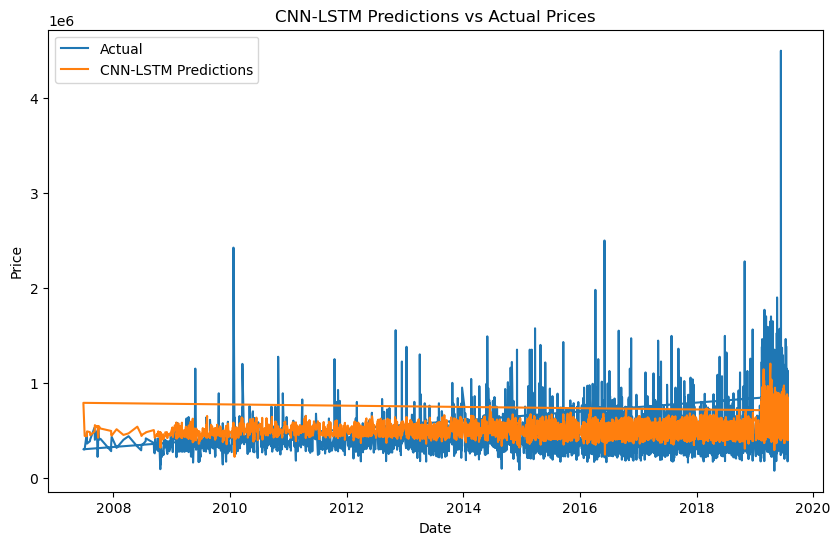

In [19]:
# Forecasting with CNN model
cnn_predictions = cnn_model.predict(X_test_cnn)

# Rescale back to original scale
cnn_predictions_rescaled = scaler.inverse_transform(cnn_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot CNN results
plt.figure(figsize=(10, 6))
plt.plot(test.index[seq_length:], y_test_rescaled, label='Actual')
plt.plot(test.index[seq_length:], cnn_predictions_rescaled, label='CNN Predictions')
plt.legend()
plt.title('CNN Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Forecasting with LSTM model
lstm_predictions = lstm_model.predict(X_test_cnn)

# Rescale back to original scale
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions)

# Plot LSTM results
plt.figure(figsize=(10, 6))
plt.plot(test.index[seq_length:], y_test_rescaled, label='Actual')
plt.plot(test.index[seq_length:], lstm_predictions_rescaled, label='LSTM Predictions')
plt.legend()
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Forecasting with CNN-LSTM model
cnn_lstm_predictions = cnn_lstm_model.predict(X_test_cnn)

# Rescale back to original scale
cnn_lstm_predictions_rescaled = scaler.inverse_transform(cnn_lstm_predictions)

# Plot CNN-LSTM results
plt.figure(figsize=(10, 6))
plt.plot(test.index[seq_length:], y_test_rescaled, label='Actual')
plt.plot(test.index[seq_length:], cnn_lstm_predictions_rescaled, label='CNN-LSTM Predictions')
plt.legend()
plt.title('CNN-LSTM Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


      Model           RMSE
0    ARIMAX  163338.249811
1   SARIMAX  209613.470080
2       CNN  200291.342811
3      LSTM  187658.504564
4  CNN-LSTM  191205.493251


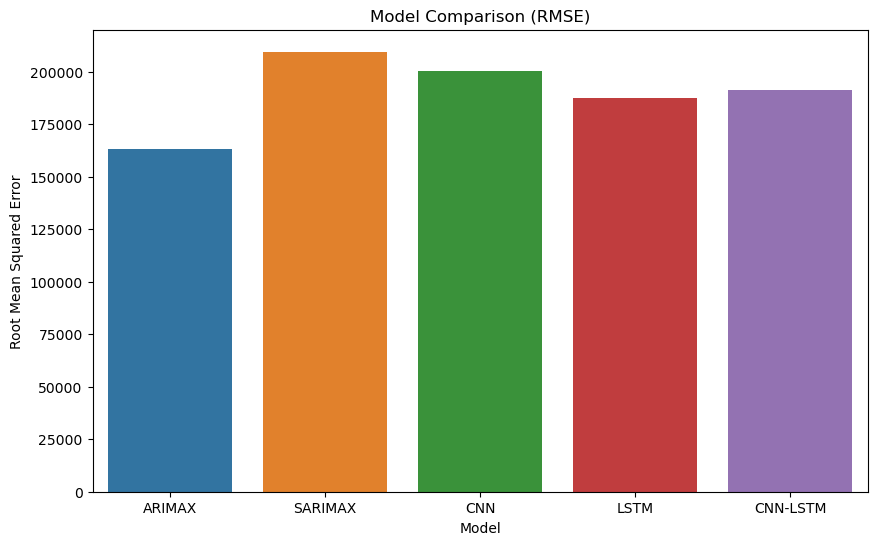

The best model is ARIMAX with RMSE of 163338.25


In [20]:
from sklearn.metrics import mean_squared_error

# this is where i will calc RMSE for each model
rmse_arimax = mean_squared_error(test['price'], arimax_forecast, squared=False)
rmse_sarimax = mean_squared_error(test['price'], sarimax_forecast, squared=False)
rmse_cnn = mean_squared_error(y_test_rescaled, cnn_predictions_rescaled, squared=False)
rmse_lstm = mean_squared_error(y_test_rescaled, lstm_predictions_rescaled, squared=False)
rmse_cnn_lstm = mean_squared_error(y_test_rescaled, cnn_lstm_predictions_rescaled, squared=False)

# Creation of a DataFrame to compare the results
results = pd.DataFrame({
    'Model': ['ARIMAX', 'SARIMAX', 'CNN', 'LSTM', 'CNN-LSTM'],
    'RMSE': [rmse_arimax, rmse_sarimax, rmse_cnn, rmse_lstm, rmse_cnn_lstm]
})

print(results)

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model Comparison (RMSE)')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.show()

# Print the best model
best_model = results.loc[results['RMSE'].idxmin()]
print(f"The best model is {best_model['Model']} with RMSE of {best_model['RMSE']:.2f}")


# end